<a href="https://colab.research.google.com/github/KenzaB27/BGNHackathon2021/blob/machine_learning/machine_learning/alphanum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environement setup

In [ ]:
import tensorflow as tf 

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
%tensorflow_version 2.x

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!echo '{"username":"kenzabouzid","key":"7fa6e6d68e8f429177c6eb453105e3c1"}' > /root/.kaggle/kaggle.json
!chmod 600  /root/.kaggle/kaggle.json
!kaggle datasets download -d kuzivakwashe/significant-asl-sign-language-alphabet-dataset
!unzip /content/significant-asl-sign-language-alphabet-dataset.zip -d significant-asl-sign-language-alphabet-dataset

In [64]:
from tensorflow import keras
from tqdm import tqdm
# Imports for Deep Learning
from keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPool2D
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet101

# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
tf.random.set_seed(2)

# Imports to view data
import cv2
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

# Image Preprocessing
from skimage.filters import sobel, scharr

import os

# Preprocessing

In [96]:
# Set global variables
TRAIN_DIR = '/content/significant-asl-sign-language-alphabet-dataset/significant-asl-alphabet-training-set/Training Set'
TEST_DIR = '/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'
# CUSTOM_TEST_DIR = '/content/asl-alphabet-test/asl-alphabet-test/'

IMG_SIZE = 64
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
TARGET_DIMS = (IMG_SIZE, IMG_SIZE, 3) # add channel for RGB
N_CLASSES = 27
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

# Model saving for easier local iterations
MODEL_DIR = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = True


In [32]:
CATEGORIES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CATEGORIES.sort()

print('Following classes were found:')
print(', '.join(CATEGORIES))

Following classes were found:
A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, space


(133, 78, 3)
(150, 67, 3)
(92, 66, 3)
(180, 118, 3)
(200, 200, 3)
(137, 82, 3)
(118, 146, 3)
(142, 188, 3)
(165, 87, 3)
(339, 450, 3)
(136, 118, 3)
(157, 165, 3)
(126, 91, 3)
(159, 95, 3)
(200, 200, 3)
(137, 92, 3)
(114, 155, 3)
(200, 200, 3)
(146, 84, 3)
(140, 86, 3)
(200, 200, 3)
(140, 64, 3)
(178, 93, 3)
(200, 200, 3)
(152, 104, 3)
(200, 200, 3)
(200, 200, 3)


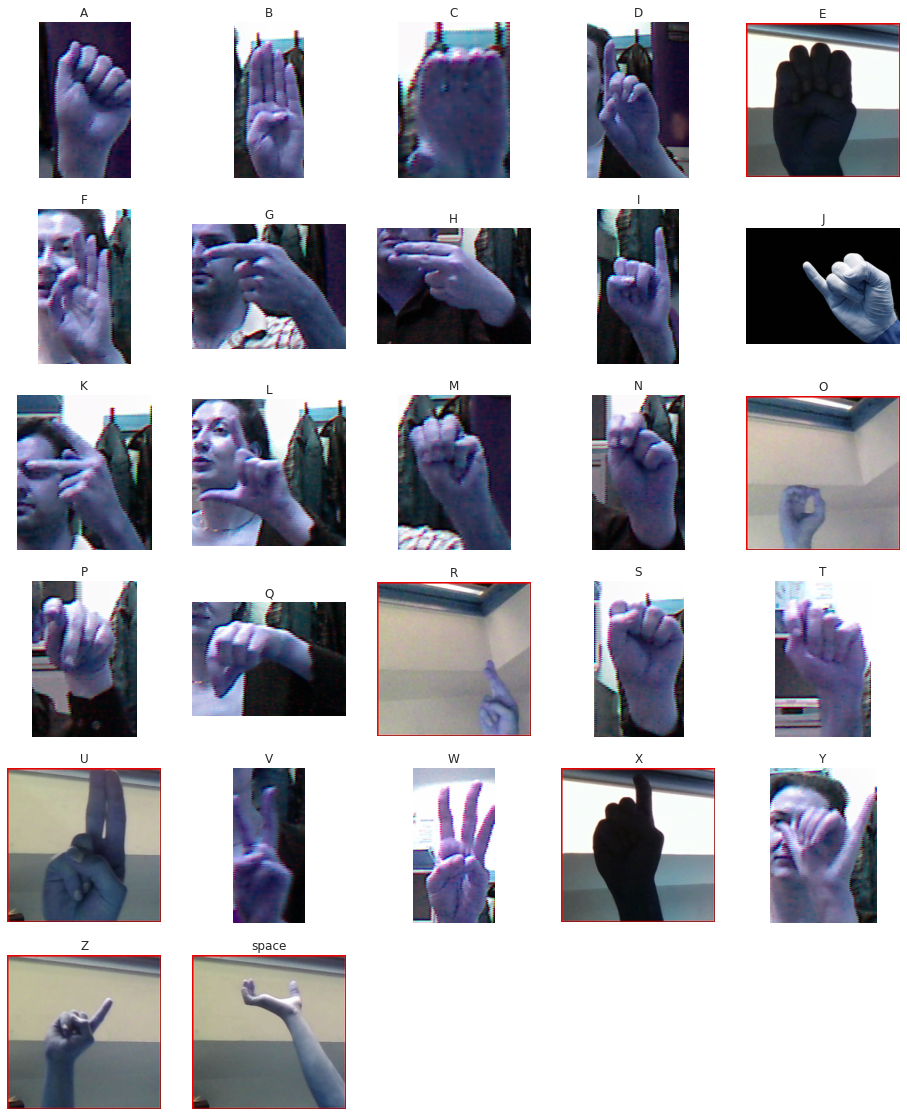

In [33]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CATEGORIES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CATEGORIES)):
        cls = CATEGORIES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        im = cv2.imread(imgs[0])
        print(im.shape)
        plt.imshow(im)
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

plot_one_sample_of_each(TRAIN_DIR)

## Test and Training Data



In [40]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....

        path = os.path.join(TRAIN_DIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
                # print(new_array.shape)
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
create_training_data() # call function

100%|██████████| 3000/3000 [00:02<00:00, 1136.76it/s]


In [41]:
import random
random.shuffle(training_data)

# Check the shuffle
for sample in training_data[:10]:
    print(sample[1])

20
24
24
7
17
0
10
4
24
0


## Split labels and features

In [47]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

np.save(MODEL_DIR+"X.npy", X)
np.save(MODEL_DIR+"Y.npy", Y)


(77490, 64, 64, 3)
(77490,)


# Build Model

Need to reprocess? True


In [78]:
with tpu_strategy.scope():

  model = Sequential()

  model.add(Conv2D(32,(3,3),padding = 'same',input_shape=TARGET_DIMS,activation = 'relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Conv2D(256,(3,3),padding = 'same',activation = 'relu'))
  model.add(MaxPool2D((2,2)))

  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(N_CLASSES,activation="softmax"))

  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [79]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 8, 8, 256)        

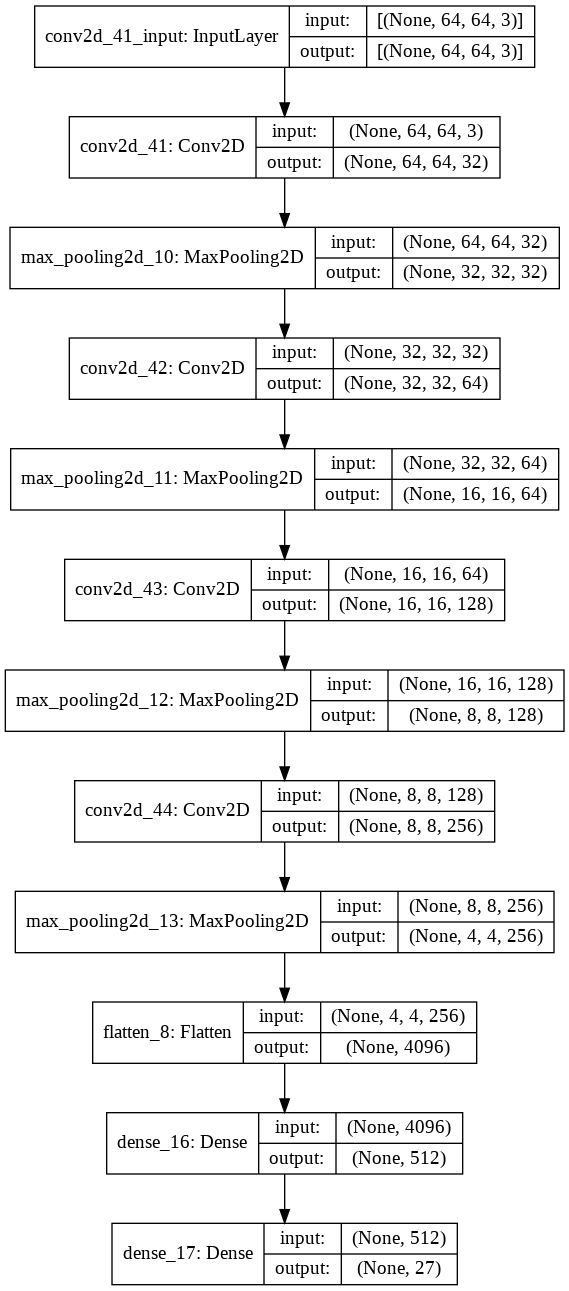

In [80]:
from tensorflow import keras
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [81]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor ='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=5, min_delta=1e-3)

history = model.fit(X, Y, batch_size=32, epochs=20, verbose=1, callbacks=[checkpoint, earlystop], 
                      validation_split=VALIDATION_SPLIT)

Epoch 1/20
1938/1938 [==============================] - 58s 27ms/step - loss: 2.3532 - accuracy: 0.6458 - val_loss: 0.2975 - val_accuracy: 0.9117

Epoch 00001: val_accuracy improved from -inf to 0.91173, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5
Epoch 2/20
1938/1938 [==============================] - 45s 23ms/step - loss: 0.2449 - accuracy: 0.9274 - val_loss: 0.2255 - val_accuracy: 0.9335

Epoch 00002: val_accuracy improved from 0.91173 to 0.93348, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5
Epoch 3/20
1938/1938 [==============================] - 46s 24ms/step - loss: 0.1770 - accuracy: 0.9466 - val_loss: 0.2349 - val_accuracy: 0.9313

Epoch 00003: val_accuracy did not improve from 0.93348
Epoch 4/20
1938/1938 [==============================] - 45s 23ms/step - loss: 0.1454 - accuracy: 0.9563 - val_loss: 0.2148 - val_accuracy: 0.9432

Epoch 00004: val_accuracy improved from 0.93348 to 0.94315, saving model to 

In [83]:
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/alpha_sign.h5'
model.load_weights(checkpoint_filepath)
model.save_weights(checkpoint_filepath)

## Evaluate model

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip /content/asl-alphabet.zip -d asl-alphabet

In [113]:
import cv2
def test_model(path, model):

  im = cv2.imread(path)

  im = cv2.resize(im, (IMG_SIZE,IMG_SIZE))
  im = im.reshape(1,IMG_SIZE,IMG_SIZE,3)

  plt.imshow(im[0])
  plt.show()
  res = model.predict(im)
  return np.argmax(res)

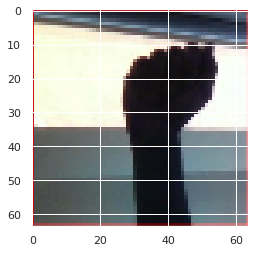

0


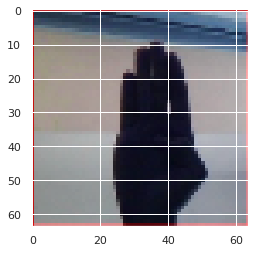

1


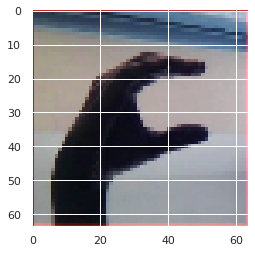

2


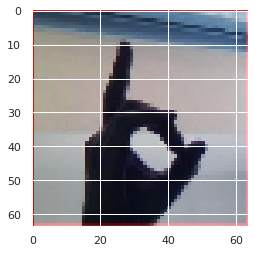

3


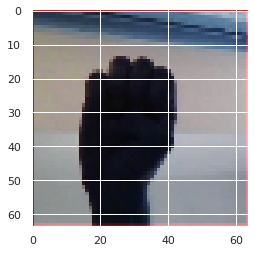

4


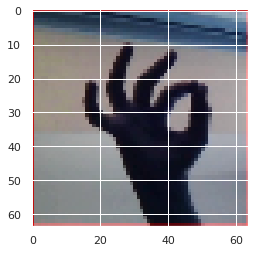

5


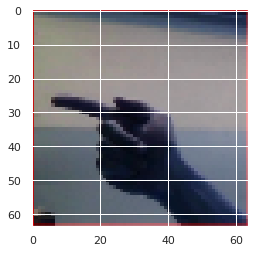

6


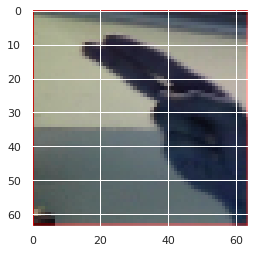

7


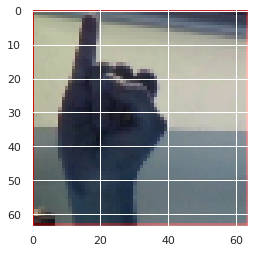

8


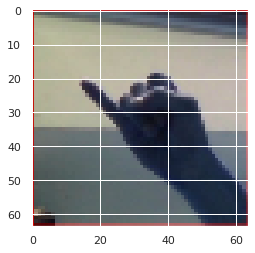

15


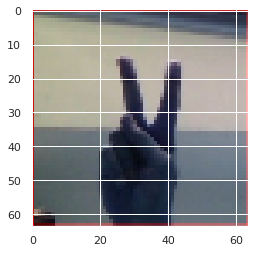

10


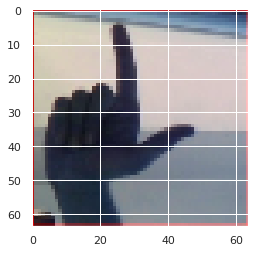

11


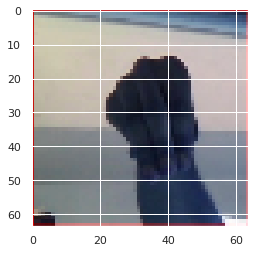

1


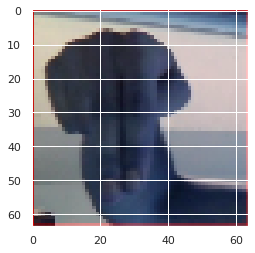

12


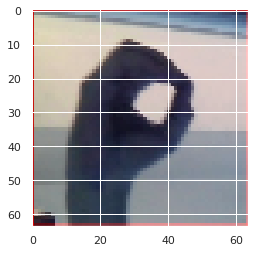

14


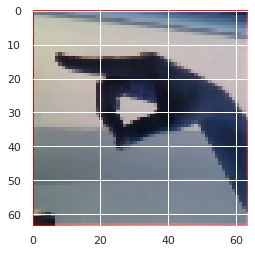

15


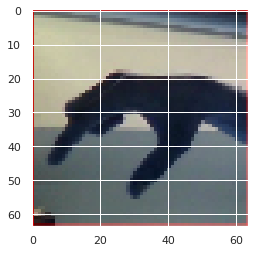

16


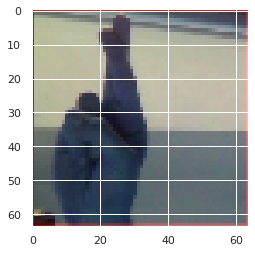

17


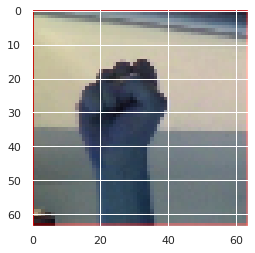

18


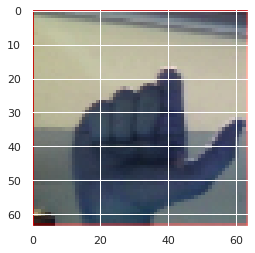

23


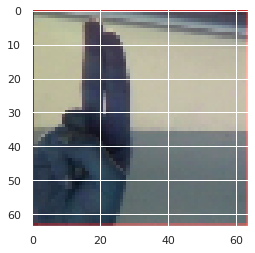

20


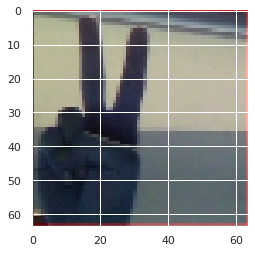

21


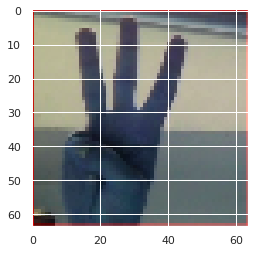

22


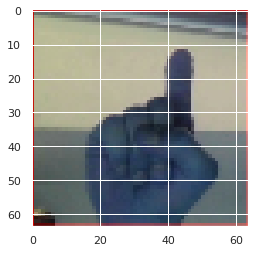

23


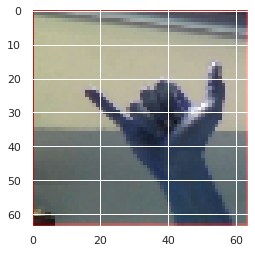

24


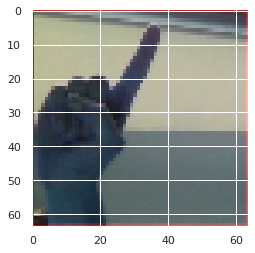

25


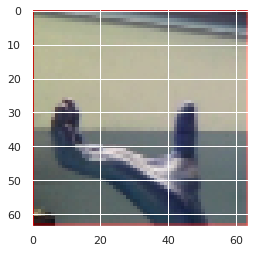

26
23


In [116]:
count = 0
for i, cat in enumerate(CATEGORIES):
  path = TEST_DIR + cat + "_test.jpg"
  prediction = test_model(path, model)
  if i == prediction: 
    count += 1 
  print(prediction)

print(count)

In [117]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(f'{checkpoint_filepath[:-2]}tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpamh3wwk7/assets


INFO:tensorflow:Assets written to: /tmp/tmpamh3wwk7/assets


ValueError: ignored